In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset

from functools import partial

import torch.utils.data as data

import numpy as np

import wandb


#einops
import einops
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import cv2
from PIL import Image

import matplotlib.pyplot as plt

import os

from tqdm import tqdm

import wandb

/home/jpierre/anaconda3/envs/myenvPy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
print(os.getcwd())

/home/jpierre/other/computer_vision


## Get data

In [4]:
#root = '/scratch/users/jpierre/data/input_tensors/input_tensors/train'
#rootTest = '/scratch/users/jpierre/data/input_tensors/input_tensors/val'

root = '/home/jpierre/other/computer_vision/data/input_tensors/input_tensors/train'
rootTest ='/home/jpierre/other/computer_vision/data/input_tensors/input_tensors/val'

In [5]:
pathlistLearning = []
for folder, sub, files in tqdm(os.walk( root)):
    print(folder)
    for file in files:
        if file.endswith('.pt'):
            pathlistLearning.append(os.path.join(folder, file))

1it [00:00, 178.46it/s]

/home/jpierre/other/computer_vision/data/input_tensors/input_tensors/train


In [6]:
pathlistTest = []
for folder, sub, files in tqdm(os.walk(rootTest)):
    for file in files:
        if file.endswith('.pt'):
            pathlistTest.append(os.path.join(folder, file))

1it [00:00, 300.41it/s]


In [7]:
badLearning = [30, 108, 110, 112, 134, 195, 196, 906, 908, 910, 912, 925, 927, 928,930, 1086, 1087, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1099, 1100, 1101, 1103,1106, 1107, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1118, 1119, 1121, 1122, 1123,1125, 1126, 1127, 1128, 1130, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1141, 1142,1143, 1144, 1146, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651,1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665,1666, 1667, 1668, 1669, 1670, 1671, 1673, 1688, 1689, 1690, 1691, 1692, 1693, 1694,1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703]
badLearning2 = [139, 440, 475, 667, 670, 672, 675, 677, 678, 1017, 1034, 1097, 1124, 1139,1426, 1672, 1680]
badLearning = list(set(badLearning + badLearning2))

badTest = [ 63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  76,  78,  81,  83,  84,  85, 86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  98, 100, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]
badTest2 = [192, 194, 218, 223, 235, 236, 239, 254]

badTest3 = [63, 64, 66, 68, 69, 70, 71, 72, 74, 76, 77, 79, 80, 81, 83, 85, 86, 87, 88, 89, 90, 93, 94, 96, 98, 99, 101, 102, 104, 105, 106, 108, 109, 111, 114, 115, 116, 117, 118, 119, 121, 122, 124, 125, 126]
badTest4 = [194, 196, 201, 202, 203, 209, 211, 222, 223, 242, 245, 247, 248]

badTest = badTest + badTest2 + badTest3 + badTest4

badTest = list(set(badTest))

In [8]:

pathlistLearning = [pathlistLearning[i] for i in range(len(pathlistLearning)) if i not in badLearning]
pathlistTest = [pathlistTest[i] for i in range(len(pathlistTest)) if i not in badTest]



print(len(pathlistLearning))
print(len(pathlistTest))

1645
755


### analyze stuff

In [9]:
def getResults(path):

    width = []
    height = []
    nbList = []

    for f in tqdm(path):
        l = torch.load(f)
        width.append(l[0].shape[0])
        height.append(l[0].shape[1])
        nbList.append(l[1])
        
    return width, height, nbList

In [10]:
w, h, yL = getResults(pathlistTest)

100%|██████████| 755/755 [00:24<00:00, 31.21it/s]


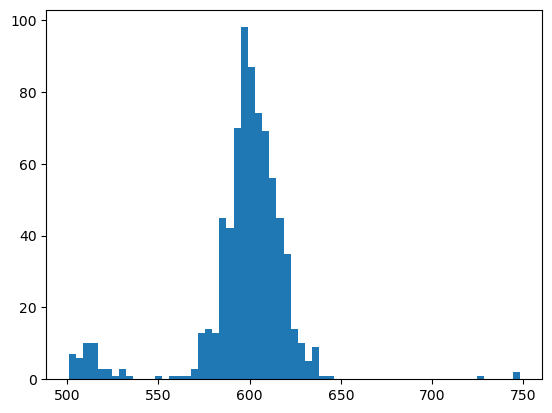

In [11]:
plt.hist(w, bins='auto')
plt.show()

## seems ok for the learning

In [12]:
w = np.array(w)
inds = np.argsort(w)
inds = np.where(w <= 500)[0]
inds2 = np.where(w > 500 )[0]
inds2bis = np.where(w[inds2] < 750)[0]
inds2 = inds2[inds2bis]
inds3 = np.where(w >= 750 )[0]

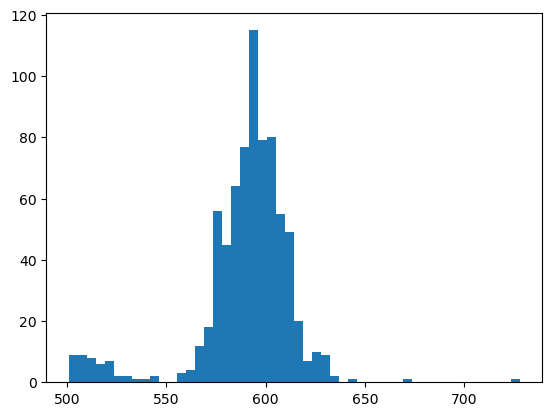

In [13]:
plt.hist(h, bins='auto')
plt.show()

## seems ok for the learning

In [14]:
h = np.array(h)
inds = np.argsort(h)
inds = np.where(h <= 500)[0]
inds2 = np.where(h > 500 )[0]
inds2bis = np.where(h[inds2] < 750)[0]
inds2 = inds2[inds2bis]
inds3 = np.where(h >= 750 )[0]

In [15]:
yL = np.array(yL)
inds = np.argsort(yL)
inds = np.where(yL <= 70)[0]
inds2 = np.where(yL > 70 )[0]
inds2bis = np.where(yL[inds2] < 140)[0]
inds2 = inds2[inds2bis]
inds3 = np.where(yL >= 140 )[0]

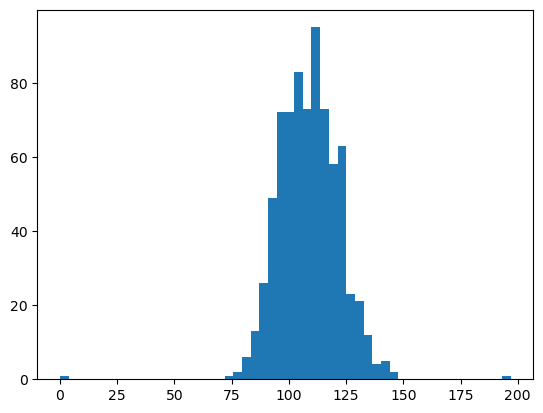

In [16]:
plt.hist(yL, bins='auto')
plt.show()

## Dataset

In [9]:
class imageDataset(Dataset):
    """
    Simple dataset. Supposed to load images and the corresponding output
    """

    def __init__(self, listPaths=list, transform=None, probs= None):
        """ 
        Args:
        -----
        - `listPaths`: list of images + number of cells [image, y]
        """
        self.data = listPaths
        self.length = len(listPaths)
        self.transform = transform
        self.probs = probs
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        l = torch.load(self.data[idx])
        x = l[0]
        try:
            x = cv2.resize(x.numpy(), (128, 128), interpolation=cv2.INTER_LINEAR)
        except:
            print(x)
            print(idx)
        y = l[1]

        if self.transform:
            x = x.astype(np.uint8)
            x = Image.fromarray(x)
            
            noTransBool = 1
            for i in range(len(self.transform)):
                randVal = np.random.random()

                if randVal <= self.probs[i]:
                    x = self.transform[i](x)
                    noTransBool = 0
                    break

            if noTransBool:
                x = self.transform[-1](x)
                
                
            x = x/255
            x = x.squeeze(0)
            return x, y, idx

        x = torch.from_numpy(x)/255
        plt.imshow(x)
        plt.show()
        
        return x, y, idx

In [10]:
pHflip = 0.4                                     # probability of applying a horizontal flip
pVflip = 0.4                                     # probability of applying a vertical flip
pInvert = 0.7
deg = 35


tr_base = transforms.Compose([
    transforms.ToTensor(),
])

trans1 = transforms.Compose([
    transforms.RandomHorizontalFlip(pHflip),
    transforms.RandomInvert(pInvert),
    transforms.RandomRotation(deg),
    transforms.ToTensor(),
])

trans_lits = [trans1, tr_base]

In [11]:

datasetLearning = imageDataset(listPaths=pathlistLearning, transform=trans_lits, probs = [0.3, 0.7])
#datasetValidation = imageDataset(data_list=dataValidation, transform=[tr_base], probs = [1])            # no augmentation for the validation or test set
datasetTest = imageDataset(listPaths=pathlistTest, transform=[tr_base], probs = [0.3, 0.7])


loaderLearning = data.DataLoader(datasetLearning, batch_size = 50, shuffle= True, num_workers = 1)
#loaderValidation = data.DataLoader(datasetValidation, batch_size = 100, shuffle= True, num_workers = 4)
loaderTest = data.DataLoader(datasetTest, batch_size = 50, shuffle= True, num_workers = 1)

In [140]:
images, labels, ids = next(iter(loaderLearning))


In [62]:
for x_val, y_val, _ in loaderLearning:
    pass

In [41]:
print(_)

tensor([741, 412, 768, 567, 382])


In [56]:
l = torch.load(pathlistTest[223])
print(l[0].shape)
print(l[1])

torch.Size([1, 0])
0


In [ ]:
for x_val, y_val, _ in loaderValidation:

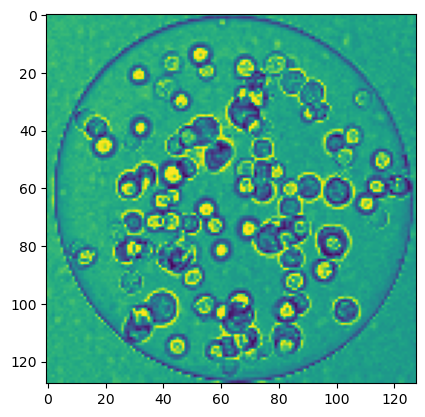

In [365]:
plt.imshow(images[0, :, :])

In [367]:
im2 = torch.tile(images[:, None, :, :], (1,3,1,1))

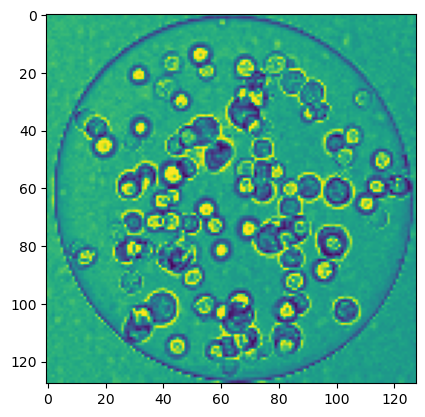

In [372]:
plt.imshow(im2[0, 1])

### Model

In [35]:
NN = models.resnet152(weights="IMAGENET1K_V2")
for param in NN.parameters():
    param.requires_grad = False

In [12]:
NN = models.efficientnet_b7(weights="IMAGENET1K_V1")

#resnet not trained later 
for param in NN.parameters():
    param.requires_grad = False
    
num_features = NN.classifier[-1].in_features
    
mlp = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(512, 64),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(64, 1),
    #nn.Softmax(dim=1)
)

NN.classifier = mlp

NN = NN.to(device)

In [19]:
mlp = nn.Sequential(
    nn.Linear(NN.fc.in_features, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 1)
)

NN.fc = mlp

NN = NN.to(device)

AttributeError: 'EfficientNet' object has no attribute 'fc'

In [37]:
class StandardizedConv(nn.Conv2d):
    """
    Based on: https: //arxiv.org/abs/1903.10520
    Code inspired from: https://github.com/joe-siyuan-qiao/WeightStandardization
    
    """

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, "o ... -> o 1 1 1", "mean")
        var = reduce(weight, "o ... -> o 1 1 1", partial(torch.var, unbiased=False))
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )

class ResBlock(nn.Module):
    def __init__(self,dim_in,dim_out,down = True,groups=4):
        super(ResBlock,self).__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.ngroups = groups
        
        if down:
            self.conv1 = StandardizedConv(dim_in,dim_in,kernel_size=3,padding = 1)
            self.group_norm1 = nn.GroupNorm(groups,dim_in)
            self.silu1 = nn.SiLU()
            self.conv2 = StandardizedConv(dim_in,dim_out,kernel_size=3,padding = 1)
            self.group_norm2 = nn.GroupNorm(groups,dim_out)
            self.silu2 = nn.SiLU()
        else:
            self.conv1 = StandardizedConv(dim_in,dim_out,kernel_size=3,padding = 1)
            self.group_norm1 = nn.GroupNorm(groups,dim_out)
            self.silu1 = nn.SiLU()
            self.conv2 = StandardizedConv(dim_out,dim_out,kernel_size=3,padding = 1)
            self.group_norm2 = nn.GroupNorm(groups,dim_out)
            self.silu2 = nn.SiLU()
        
        if dim_in == dim_out:    
            self.residual_conn = nn.Identity()
        else:
            self.residual_conn = nn.Conv2d(dim_in,dim_out,1)
            
    def forward(self,x):
        h = x
        h = self.conv1(h)
        h = self.group_norm1(h)
        h = self.silu1(h)
        h = self.conv2(h)
        h = self.group_norm2(h)
        h = self.silu2(h)
        
        return h + self.residual_conn(x)
    
class Downsample(nn.Sequential):
    def __init__(self,factor):
        super(Downsample,self).__init__()
        self.pool = nn.MaxPool2d(factor)

class Upsample(nn.Sequential):
    def __init__(self,factor,chan_in):
        super(Upsample,self).__init__()
        self.up = nn.Upsample(scale_factor=factor, mode="nearest")
        self.conv = nn.Conv2d(chan_in, int(chan_in/2),kernel_size=1)
        
        
class Unetvf(nn.Module):
    def __init__(self,c_in_net,img_size, nbColors = 3):
        super(Unetvf,self).__init__()
        #convert Nbatch x 3 x im_size x im_size into Nbatch x 64 x im_size x im_size
        c_in = nbColors
        self.init_conv = nn.Conv2d(c_in,c_in_net,1)
                
        #Down part of the U
        #x0: Nbatch x 64 x img_size x img_size
        self.resD1 = ResBlock(c_in_net,c_in_net)
        #x1: Nbatch x 64 x 64 x 64
        self.down1 = Downsample(2)
        
        #x2: Nbatch x 64 x 32 x 32
        self.resD2 = ResBlock(c_in_net,c_in_net*2,256)
        #x3: Nbatch x 128 x 32 x 32
        self.down2 = Downsample(2)
        
        #x5: Nbatch x 128 x 16 x 16
        self.resD3 = ResBlock(c_in_net*2,c_in_net*4,256)
        #x6: Nbatch x 256 x 16 x 16
        self.down3 = Downsample(2)
        

        self.resD4 = ResBlock(c_in_net*4,c_in_net*8,256)
        self.resD5 = ResBlock(c_in_net*8,c_in_net*8,256)
        
        #x10: 512 x 8 x 8
        self.up1 = Upsample(2,c_in_net*8)

        
        #x12: 512 x 16 x 16
        self.resU1 = ResBlock(c_in_net*8, c_in_net*4,256)
        #x13: 256 x 16 x 16
        self.up2 = Upsample(2,c_in_net*4)
        
        #x14: 128 x32 x32

        self.resU2 = ResBlock(c_in_net*4, c_in_net*2,256)
        #x16: 128 x 32 x 32
        self.up3 = Upsample(2,c_in_net*2)
        #x17: 64 x 64 x 64
        

        self.resU3 = ResBlock(c_in_net*2, c_in_net*1,256)
        #x19: 64 x 64 x 64
        self.end_conv = nn.Conv2d(c_in_net,c_in,1)
        #x20
    def forward(self,x,t):
        x0 = self.init_conv(x)
        x1 = self.resD1(x0)
        x2 = self.down1(x1)
        
        x3 = self.resD2(x2)
        x4 = self.down2(x3)
        
        x6 = self.resD3(x5)
        x7 = self.down3(x6)
        x8 = self.att2(x7)
        x9 = self.resD4(x8)
        x10 = self.att3(x9)
        x10 = self.resD5(x10)
        x11 = self.up1(x10)
        x12 = self.ca1(x6,x11)
        x13 = self.resU1(x12)
        x14 = self.up2(x13)
        x15 = torch.cat((x3,x14),1)
        x16 = self.resU2(x15)
        x17 = self.up3(x16)
        x18 = torch.cat((x1,x17),1)
        x19 = self.resU3(x18)
        x20 = self.end_conv(x19)
        return x20
    
    
    
    
    
class UNet(nn.Module):
    def __init__(self,c_in_net,img_size, nbColors = 3):
        super(UNet,self).__init__()
        
        # could change for [N, K, img_size, img_size] ???
        ## Turn the input from [N, 3, img_size, img_size] into [N, img_size, img_size, img_size]
        c_in = nbColors
        self.init_conv = nn.Conv2d(c_in,c_in_net,1)
                
        ## Down part of the UNet
        #[N x img_size x img_size x img_size]
        self.resD1 = ResBlock(c_in_net,c_in_net)
        self.down1 = Downsample(2)
        
        # [Nbatch x img_size x (img_size/2) x (img_size/2)]
        self.resD2 = ResBlock(c_in_net,c_in_net*2)
        self.down2 = Downsample(2)
        
        # [Nbatch x img_size x (img_size/4) x (img_size/4)]
        self.resD3 = ResBlock(c_in_net*2,c_in_net*4)
        self.down3 = Downsample(2)
        
        # [Nbatch x img_size x (img_size/8) x (img_size/8)]
        
        ## Lowest part
        self.resD4 = ResBlock(c_in_net*4,c_in_net*8)
        self.resD5 = ResBlock(c_in_net*8,c_in_net*8)
        
        
        ## Up part of the UNet
        self.up1 = Upsample(2,c_in_net*8)
        
        # [Nbatch x img_size x (img_size/4) x (img_size/4)]
        
        self.resU1 = ResBlock(c_in_net*8, c_in_net*4)
        self.up2 = Upsample(2,c_in_net*4)
        
        # [Nbatch x img_size x (img_size/2) x (img_size/2)]
        
        self.resU2 = ResBlock(c_in_net*4, c_in_net*2)
        self.up3 = Upsample(2,c_in_net*2)
        
        # [Nbatch x img_size x img_size x img_size]
        

        self.resU3 = ResBlock(c_in_net*2, c_in_net*1)
        #x19: 64 x 64 x 64
        self.end_conv = nn.Conv2d(c_in_net,c_in, 1)
        #x20
    def forward(self,x):
        x0 = self.init_conv(x)
        x1 = self.resD1(x0)
        x2 = self.down1(x1)
        
        #print(f'shape -- {x2.shape}')
        
        x3 = self.resD2(x2)
        x4 = self.down2(x3)
        
        #print(f'shape -- {x4.shape}')
        
        x6 = self.resD3(x4)
        x7 = self.down3(x6)
        
        #print(f'shape -- {x7.shape}')
        
        #print('stop down')
        
        x9 = self.resD4(x7)
        x10 = self.resD5(x9)
        
        #print('UP')
        
        #print(f'shape -- {x10.shape}')
        
        x11 = self.up1(x10)
        x12 = torch.cat((x6,x11),1)
        x13 = self.resU1(x12)
        #print(f'shape -- {x13.shape}')
        
        x14 = self.up2(x13)
        x15 = torch.cat((x3,x14),1)
        
        x16 = self.resU2(x15)
        x17 = self.up3(x16)
        x18 = torch.cat((x1,x17),1)
        
        x19 = self.resU3(x18)
        x20 = self.end_conv(x19)
        return x20
    
class MLP(nn.Module): 
    def __init__(self,inputShape, outputShape):
        super(MLP,self).__init__()
        mlp = nn.Sequential(
            nn.Linear(inputShape, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

In [25]:
class Layer2MLP(nn.Sequential):
    """ 
    Simple 2 layer MLP
    """
    def __init__(self, inputShape:int, outputShape:int, hiddenShape=None):
        """
        Simple 2-layer MLP
        
        Args:
        -----
        - `inputShape`: shape of the input vector
        - `outputShape`: shape of the output vector
        - `hiddenShape`: shape of the hidden layer
                         if not defined half of inputShape
        """
        
        ## define the basic value if not defined
        if hiddenShape is None:
            hiddenShape = inputShape // 2
            
        ## sequential NN
        super().__init__(
            nn.Linear(inputShape, hiddenShape),
            nn.ReLU(),
            nn.Linear(hiddenShape, hiddenShape),
            nn.ReLU(),
            nn.Linear(hiddenShape, outputShape),
        )

In [23]:
import torch
import torch.nn as nn

# Define convolutional layer
conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)

# Input tensor shape (batch_size, channels, height, width)
input_tensor = torch.randn((1, 3, 128, 128))

# Perform forward pass
output_tensor = conv(input_tensor)

# Get the output shape
output_shape = output_tensor.shape

print("Input shape:", input_tensor.shape)  # Input spatial size (height, width)
print("Output shape:", output_shape)       # Output spatial size (height, width)


Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


In [26]:
class net(nn.Module):
    def __init__(self,c_in_net, img_size, nbColors = 3, hiddenShape=None):
        super(net,self).__init__()
        self.unet = UNet(c_in_net,img_size, nbColors)
        
        L = img_size * img_size * nbColors
        
        self.mlp = Layer2MLP(L, 1, hiddenShape = hiddenShape)
        
        
    def forward(self, x):
        x = self.unet(x)
        x = x.reshape(x.shape[0], -1)
        x = self.mlp(x)
        return x

In [27]:
NN = net(64, 128, 1).to(device)


In [61]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [62]:
get_n_params(m)

256

In [41]:
x = torch.rand((10, 1, 128, 128))


In [42]:
print(NN(x).shape)

shape -- torch.Size([10, 64, 64, 64])
shape -- torch.Size([10, 128, 32, 32])
shape -- torch.Size([10, 256, 16, 16])
stop down
UP
shape -- torch.Size([10, 512, 16, 16])
shape -- torch.Size([10, 256, 32, 32])
torch.Size([10, 1])


In [36]:
## test

conv2d = StandardizedConv(64, 64, kernel_size = 1)
x = torch.rand((10, 64, 64, 3))
print(x.shape)
print(conv2d(x).shape)

torch.Size([10, 64, 64, 3])
torch.Size([10, 64, 64, 3])


In [26]:
imTest = torch.rand((10, 3, 900, 900))

### Learning

In [13]:
nbEpoch=10000
loaderLearning = loaderLearning
loaderValidation = loaderTest
loaderTest = loaderTest
decay = .00001

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(NN.parameters(), lr=0.005, weight_decay=5e-4)

In [14]:
wandb.init(project = 'master_thesis', name = "efficient-2")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jepi1202 (uliege_action_spotting_2022_2023_context). Use `wandb login --relogin` to force relogin


In [ ]:
def train():

    j = 0

    for i in range(nbEpoch):

        NN.train()

        for x, y, idx in tqdm(loaderLearning):
            x = x[:, None, :, :].to(device)
            
            # for resnet
            x = torch.tile(x, (1,3,1,1))
            y = y.to(device)

            out =  NN(x)

            loss = criterion(out.reshape(-1), y.reshape(-1).float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if ((j+1) % 5) == 0:
                wandb.log({'epoch': i, 'Training Loss': loss})

            if ((j+1) % 500) == 0:
                NN.eval()
                with torch.no_grad():
                    val_loss = 0
                    ylist = []
                    yFound = []
                    for x_val, y_val, _ in loaderTest:
                        x_val = x_val[:, None, :, :].to(device)
                        x_val = torch.tile(x_val, (1,3,1,1))
                        y_val = y_val.to(device)

                        out = torch.round(NN(x_val))
                        
                        for k in range(len(y_val)):
                            ylist.append(y_val.reshape(-1)[k].float().item())
                            yFound.append(out.reshape(-1)[k].item())

                        val_loss += criterion(out.reshape(-1), y_val.reshape(-1).float())

                    yFound = np.array(yFound)
                    ylist = np.array(ylist)
                    var = np.var(yFound - ylist)
                    
                    
                    wandb.log({'epoch': i, 'Validation Loss': val_loss / len(datasetTest), 'var':var})
                    
                    plt.hist(yFound - ylist, bins = 'auto')
                    wandb.log({'difference':wandb.Image(plt)})
                    plt.close()
                    
                    plt.hist(yFound, bins = 'auto')
                    wandb.log({'predictions':wandb.Image(plt)})
                    plt.close()
                    
                NN.train()
                
                torch.save(NN.state_dict(), "model_efficientNetB7.pt")

            j += 1
            
if __name__ == "__main__":
    # Initialize your model, dataloaders, criterion, optimizer, wandb, and device

    train()

100%|██████████| 33/33 [00:04<00:00,  8.01it/s]


100%|██████████| 33/33 [00:04<00:00,  7.97it/s]


100%|██████████| 33/33 [00:04<00:00,  8.00it/s]


100%|██████████| 33/33 [00:04<00:00,  7.99it/s]


100%|██████████| 33/33 [00:04<00:00,  7.97it/s]


100%|██████████| 33/33 [00:04<00:00,  7.97it/s]


100%|██████████| 33/33 [00:04<00:00,  7.96it/s]


100%|██████████| 33/33 [00:04<00:00,  7.99it/s]


100%|██████████| 33/33 [00:07<00:00,  4.32it/s]


 45%|████▌     | 15/33 [00:01<00:02,  8.72it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 33/33 [00:04<00:00,  8.08it/s]


 79%|███████▉  | 26/33 [00:06<00:00,  7.74it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 15%|█▌        | 5/33 [00:00<00:03,  7.05it/s]